Le problème de Simon

Soit une boite noire définie par un comportement spécifique soit un-à-un soit deux-à-un

un-à-un définie un mapping de la fonction dans lequel il y a exactement une unique image pour chaque antécédent.

deux-à-un définie un mapping de la fonction dans lequel il y a exactement une pair d'antécédent possédant la même image.

En s'accordant sur ces règles, on peut supposer qu'il existe une variable caché b tel que :
Soit X1, X2 : f(X1)=f(X2)
Alors X1 = X2 XOR b

Le problème étant de connaitre qu'elle est la valeur de b afin de déterminer le comportement de la fonction.
Bien entendu en moins de requêtes possibles.

Partir sur une solution classique serait terriblement long car dans le pire des cas, nous pourrinons établir 2^{n-1} + 1 itérations.
Ce qui représente un problème algortihmique O(2^n).
Résoudre avec un ordinateur classique serait inimaginable.

Solution Quantique

In [1]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle


Implémentons notre algorithme sur un exemple avec 3 Qubits et avec b = 110

La fonction simon_oracle importé créait un oracle Simon pour l'utilisation de la variable b, définissant notre variable secrète. 

In [11]:
b = '101'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit.h(range(n))    
    
# Apply barrier for visual separation
simon_circuit.barrier()

simon_circuit += simon_oracle(b)

# Apply barrier for visual separation
simon_circuit.barrier()

# Apply Hadamard gates to the input register
simon_circuit.h(range(n))

# Measure qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()


┌───┐ ░                           ░ ┌───┐┌─┐      
q_0: ┤ H ├─░───■──────────────■────■───░─┤ H ├┤M├──────
     ├───┤ ░   │              │    │   ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├─░───┼────■─────────┼────┼───░─┤ H ├─╫─┤M├───
     ├───┤ ░   │    │         │    │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─░───┼────┼────■────┼────┼───░─┤ H ├─╫──╫─┤M├
     └───┘ ░ ┌─┴─┐  │    │  ┌─┴─┐  │   ░ └───┘ ║  ║ └╥┘
q_3: ──────░─┤ X ├──┼────┼──┤ X ├──┼───░───────╫──╫──╫─
           ░ └───┘┌─┴─┐  │  └───┘  │   ░       ║  ║  ║ 
q_4: ──────░──────┤ X ├──┼─────────┼───░───────╫──╫──╫─
           ░      └───┘┌─┴─┐     ┌─┴─┐ ░       ║  ║  ║ 
q_5: ──────░───────────┤ X ├─────┤ X ├─░───────╫──╫──╫─
           ░           └───┘     └───┘ ░       ║  ║  ║ 
c: 3/══════════════════════════════════════════╩══╩══╩═
                                               0  1  2

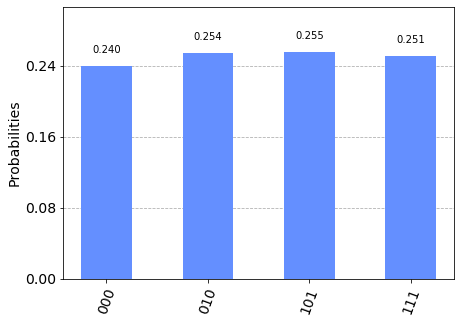

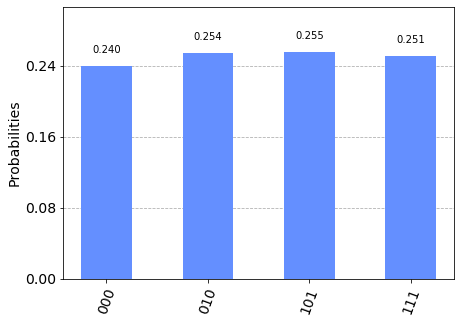

In [12]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(simon_circuit, shots=shots)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)


Puisque nous connaissons notre variable secrète b, nous pouvons facilement vérifier que b*z = 0 mod(2)

Dans le cadre idéal (déjà relativement proche), il aurait fallut que les 4 résultats aient exactement la même probabilité d'apparition.

In [13]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )


101.000 = 0 (mod 2)
101.010 = 0 (mod 2)
101.101 = 0 (mod 2)
101.111 = 0 (mod 2)


L'équation théorique pour valider les résultats est : b AND z = 0 (mod 2), où b est le bistring et z l'un des résultats.

À l'aide de ces équations, nous pouvons en déduire que b = 110, à l'aide d'une résolution simultané de ces équations.

2ème exemple

Dans ce cas de figure, nous allons appliquer l'algorithme sur un vrai ordinateur quantique (IBM).

Prenons b = 11, avec deux registres de 2 Qubits chacun.

In [15]:
b = '11'
n = len(b)
simon_circuit_2 = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit_2.h(range(n))

simon_circuit_2.barrier()

# Query oracle
simon_circuit_2 += simon_oracle(b)

simon_circuit_2.barrier()

# Apply Hadamard gates to the input register
simon_circuit_2.h(range(n))

# Measure qubits
simon_circuit_2.measure(range(n), range(n))
simon_circuit_2.draw()


┌───┐ ░                      ░ ┌───┐┌─┐   
q_0: ┤ H ├─░───■─────────■────■───░─┤ H ├┤M├───
     ├───┤ ░   │         │    │   ░ ├───┤└╥┘┌─┐
q_1: ┤ H ├─░───┼────■────┼────┼───░─┤ H ├─╫─┤M├
     └───┘ ░ ┌─┴─┐  │  ┌─┴─┐  │   ░ └───┘ ║ └╥┘
q_2: ──────░─┤ X ├──┼──┤ X ├──┼───░───────╫──╫─
           ░ └───┘┌─┴─┐└───┘┌─┴─┐ ░       ║  ║ 
q_3: ──────░──────┤ X ├─────┤ X ├─░───────╫──╫─
           ░      └───┘     └───┘ ░       ║  ║ 
c: 2/═════════════════════════════════════╩══╩═
                                          0  1

In [6]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Execute and monitor the job
from qiskit.tools.monitor import job_monitor
shots = 1024
transpiled_simon_circuit = transpile(simon_circuit_2, backend, optimization_level=3)
qobj = assemble(transpiled_simon_circuit, shots=shots)
job = backend.run(qobj)
job_monitor(job, interval=2)


least busy backend:  ibmq_quito


/tmp/ipykernel_51852/856394561.py:13: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


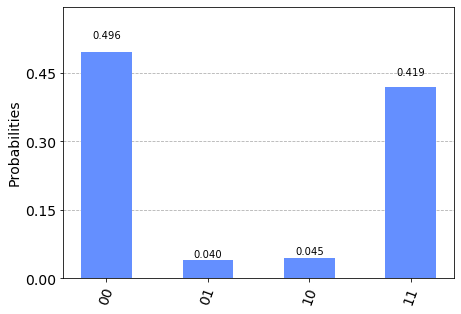

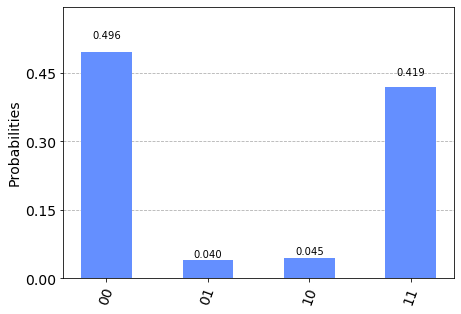

In [7]:
# Get results and plot counts
device_counts = job.result().get_counts()
plot_histogram(device_counts)


A peu de chose près, nous obtenons un résultat conforme aux attentes.

Dans le meilleurs des cas, |00⟩ et |11⟩ doivent être à 50% de probabilité et le reste à 0%.

Puisqu'ils doivent à conforme à l'équation théorique.

In [8]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

print('b = ' + b)
for z in device_counts:
    print( '{}.{} = {} (mod 2) ({:.1f}%)'.format(b, z, bdotz(b,z), device_counts[z]*100/shots))


b = 11
11.00 = 0 (mod 2) (49.6%)
11.01 = 1 (mod 2) (4.0%)
11.10 = 1 (mod 2) (4.5%)
11.11 = 0 (mod 2) (41.9%)


Nous remarquons que les résultats les plus prépondérant sont pour lequel b*z = 0 (mod 2).

Nous avons aussi dans ce cas de figure quelques erreurs mais dont la probabilité d'apparition est bien moindre que le reste.

Au final, l'algorithme quantique nous permet de retrouver le bitstring secret par une succession d'étape moins conséquentes que si cela avait été réalisé par un ordinateur classique.

Les résultats en sortie de l'algorithme sont supposés être ceux qui permettent de vérifier l'équation : b AND z = 0 (mod 2).
La vérification de la validité des résultats est simple.